# Carls' Implementation of QAOA

References:

https://qiskit.org/textbook/ch-applications/qaoa.html

In [2]:
!pip3 install qiskit
import networkx as nx
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter
from qiskit.tools.visualization import circuit_drawer
from qiskit.visualization import plot_histogram


from scipy.optimize import minimize


## Create QUBO Instance

We first create an instance of a Quadratic Unconstrained Binary Optimization problem.

In this example, we solve the Max-Cut problem

In [14]:
enable_user_graph_input = True

In [38]:
def get_user_graph():
    G = nx.Graph()
    n_nodes = int(input('Enter number of nodes: '))
    print('Now add edges.  Enter "done" to finish.')
    nodes_list = list(range(n_nodes))
    edges_list = []
    while True:
        nodes = input('Enter pair of nodes for edge "u, v": ')
        if nodes == 'exit':
            break
        u, v = nodes.split(',')
        edges_list.append((int(u), int(v)))
    G.add_nodes_from(nodes_list)
    G.add_edges_from(edges_list)
    print(edges_list)
    return G

Enter number of nodes:  4


Now add edges.  Enter "done" to finish.


Enter pair of nodes for edge "u, v":  1, 2
Enter pair of nodes for edge "u, v":  3, 4
Enter pair of nodes for edge "u, v":  exit


[(1, 2), (3, 4)]


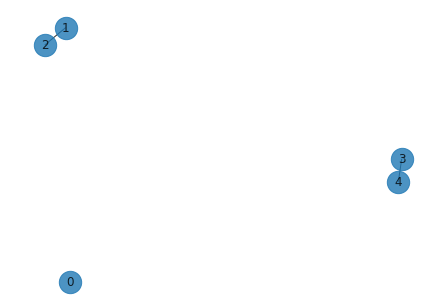

In [39]:
n_qubits = 7
p = 1
shots = 1000

if enable_user_graph_input:
    G = get_user_graph()
else:
    G = nx.Graph()
    G.add_nodes_from([0, 1, 2, 3,4,5])
    # G.add_edges_from([(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)])
    G.add_edges_from([(0, 1), (1, 2), (1, 3), (3, 4), (4,5), (4,6)])
    
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)


## Convert to Quantum Circuit

### Create Mixing Quantum Circuit

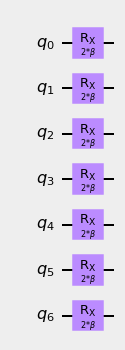

In [4]:
def create_mixing_qc(n_qubits, beta):
    qc_mix = QuantumCircuit(n_qubits)
    for i in range(0, n_qubits):
        qc_mix.rx(2 * beta, i)
    return qc_mix

qc = create_mixing_qc(n_qubits, Parameter("$\\beta$"))

circuit_drawer(qc, output='mpl', style={'backgroundcolor': '#EEEEEE'})

        

### Create Problem Quantum Circuit

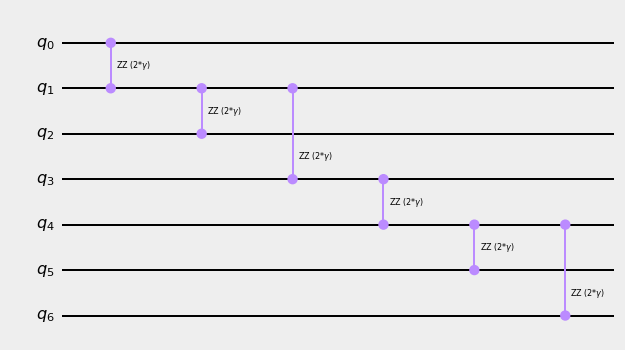

In [5]:
def create_graph_problem_qc(G, n_qubits, gamma):
    qc_p = QuantumCircuit(n_qubits)
    for pair in list(G.edges()):  # pairs of nodes
        qc_p.rzz(2 * gamma, pair[0], pair[1])
        # qc_p.barrier()
    return qc_p

qc = create_graph_problem_qc(G, n_qubits, Parameter("$\\gamma$"))
circuit_drawer(qc, output='mpl', style={'backgroundcolor': '#EEEEEE'})         

### Create Initial State

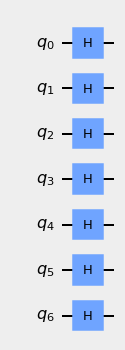

In [6]:
def create_initial_qc(n_qubits):
    qc_0 = QuantumCircuit(n_qubits)
    for i in range(0, n_qubits):
        qc_0.h(i)
    return qc_0

qc = create_initial_qc(n_qubits)
circuit_drawer(qc, output='mpl', style={'backgroundcolor': '#EEEEEE'})         

### Combine into QAOA Circuit

This is the complete circuit determined by our parameters which we will now run on Quantumn Computer.

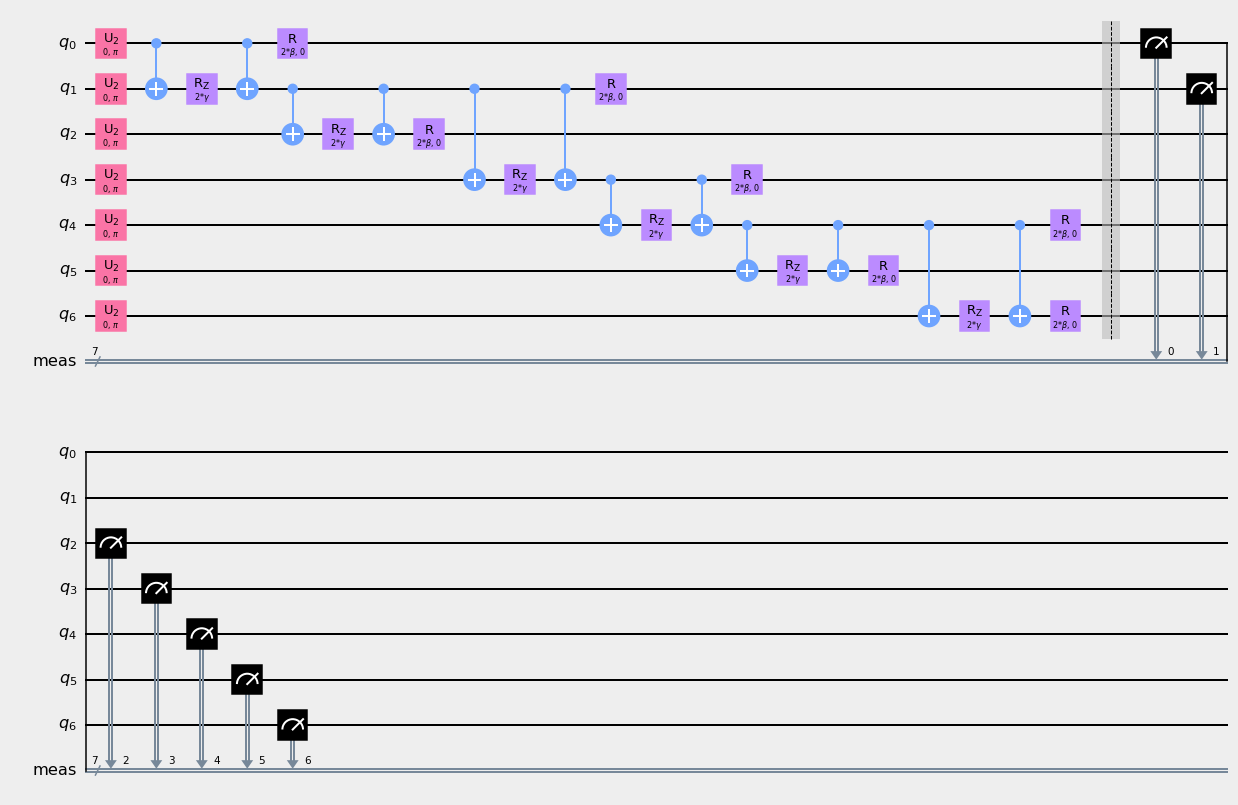

In [7]:
def create_qaoa_circ(n_qubits, problem_qc_generator, mixing_qc_generator, 
                     beta_list, gamma_list):
    qc = QuantumCircuit(n_qubits)
    
    # Add initial state and specify which qubits to attach
    attach_qubits = [i for i in range(0, n_qubits)]
    qc.append(create_initial_qc(n_qubits), attach_qubits[:])
    
    assert len(beta_list) == len(gamma_list), 'Beta and gamma list must \
        be the same length'
    n_reps = len(beta_list)
    
    # Now add repeated applications of problem and mixing circuits
    for rep in range(0, n_reps):
        qc.append(problem_qc_generator(n_qubits, gamma_list[rep]), attach_qubits[:])
        qc.append(mixing_qc_generator(n_qubits, beta_list[rep]), attach_qubits[:])
    
    qc.measure_all()
    return qc

beta = Parameter("$\\beta$")
gamma = Parameter("$\\gamma$")
beta_list = [beta for _ in range(p)]
gamma_list = [gamma for _ in range(p)]

# Define wrappers for problem qc and mixing qc generator.
# This allows us to solve a variety of QUBO problems with the same stack.
def graph_qc_generator(n_qubits, gamma):
    return create_graph_problem_qc(G, n_qubits, gamma)

def mixing_qc_generator(n_qubits, beta):
    return create_mixing_qc(n_qubits, beta)


qc = create_qaoa_circ(n_qubits, graph_qc_generator, mixing_qc_generator,
                      beta_list, gamma_list)

# Decompose to show individual elements, then draw
circuit_drawer(qc.decompose().decompose(), output='mpl', style={'backgroundcolor': '#EEEEEE'})         

### Create helper method to calculate expection

In [8]:
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
            
    return obj


def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring[::-1], G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count


def get_expectation(problem_qc_generator, mixing_qc_generator, n_qubits, shots=512):
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    
    backend = Aer.get_backend('qasm_simulator')
    
    def execute_circ(theta):
        print('new_iter')
        midpt = len(theta) // 2
        beta_list = theta[:midpt]
        gamma_list = theta[midpt:]
        
        qc = create_qaoa_circ(n_qubits, problem_qc_generator, mixing_qc_generator,
                          beta_list, gamma_list)
        # Have to decompose in order to run backend
        counts = backend.run(qc.decompose().decompose(), seed_simulator=10, 
                             shots=shots).result().get_counts()

        return compute_expectation(counts, G)
    
    return execute_circ

def graph_qc_generator(n_qubits, gamma):
    return create_graph_problem_qc(G, n_qubits, gamma)

def mixing_qc_generator(n_qubits, beta):
    return create_mixing_qc(n_qubits, beta)

# This returns a function which can optimize classically
get_expectation(graph_qc_generator, mixing_qc_generator, n_qubits, shots)


<function __main__.get_expectation.<locals>.execute_circ(theta)>

### Run QAOA

In [10]:
def qaoa(problem_qc_generator, mixing_qc_generator, n_qubits, shots):
    
    expectation = get_expectation(problem_qc_generator, mixing_qc_generator, 
                                  n_qubits, shots)

    initial_theta_value = [1.0 for _ in range(p * 2)]
    res = minimize(expectation, 
                   initial_theta_value,
                   method='COBYLA',
                   tol=0.001)
    
    return res
    
res = qaoa(graph_qc_generator, mixing_qc_generator, n_qubits, shots)
print(res)
print(res.x)

new_iter
new_iter
new_iter
new_iter
new_iter
new_iter
new_iter
new_iter
new_iter
new_iter
new_iter
new_iter
new_iter
new_iter
new_iter
new_iter
new_iter
new_iter
new_iter
new_iter
new_iter
new_iter
new_iter
new_iter
new_iter
new_iter
new_iter
new_iter
new_iter
new_iter
new_iter
new_iter
new_iter
new_iter
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -4.53
       x: [ 1.182e+00  4.188e-01]
    nfev: 34
   maxcv: 0.0
[1.18160947 0.41875387]


{'0100100': 1, '0111010': 5, '0111111': 9, '1011110': 2, '0110000': 9, '0111110': 4, '0001000': 11, '0000111': 1, '0001110': 6, '1110011': 13, '0011110': 9, '1010000': 13, '0000011': 13, '0110111': 16, '1111101': 29, '0100101': 10, '1000000': 7, '0001001': 13, '1110110': 8, '1111001': 3, '1111011': 9, '1110010': 28, '1000101': 6, '1110111': 6, '0101011': 23, '0110001': 34, '1011111': 13, '0100111': 8, '0000100': 10, '1001011': 45, '1111110': 11, '1110001': 6, '1111010': 63, '0010111': 24, '1110100': 14, '0001011': 12, '0011000': 62, '1111000': 3, '0010000': 19, '1011001': 27, '0101110': 36, '1001001': 103, '0101000': 24, '0011001': 182, '0101101': 244, '0101100': 95, '0101010': 180, '0000110': 8, '0010001': 76, '1100101': 123, '1010110': 103, '1010011': 111, '0111101': 95, '0111100': 32, '1100011': 182, '0101111': 3, '0101001': 99, '1000011': 31, '1011010': 7, '1011011': 2, '0010011': 244, '1100001': 7, '1010111': 8, '0001100': 15, '1101100': 279, '1101101': 786, '1100010': 469, '10010

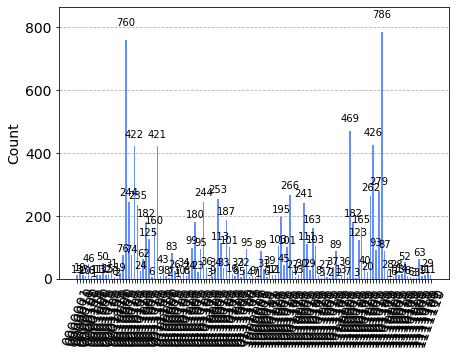

In [11]:
backend = Aer.get_backend('aer_simulator')

def graph_qc_generator(n_qubits, gamma):
    return create_graph_problem_qc(G, n_qubits, gamma)

def mixing_qc_generator(n_qubits, beta):
    return create_mixing_qc(n_qubits, beta)

beta, gamma = res.x

qc = create_qaoa_circ(n_qubits, graph_qc_generator, mixing_qc_generator,
                          [beta], [gamma])

counts = backend.run(qc.decompose().decompose(), seed_simulator=10, shots=10000).result().get_counts()


# Print out bitstring

print(counts)
s = []
max_val = 0
for _ in counts.values():
    s.append(_)

s.sort()
viz = s[-2:]
for k, v in counts.items():
    if v in viz:
        print(k[::-1])

print(sum(s))

plot_histogram(counts)